# Introduction

This Notebook is part of the final course in Google's Data Analytics courses on Coursera, *Google Data Analytics Capstone: Complete a Case Study*.

I looked through the case studies offered by the course, but decided to take the third option and make my own project.
For some time, I have been tracking my Weight, Sleep, or Activity using products offered by Xiaomi, including a MiBad 4, 5 (which was upgraded to 6) and a MiScale 2 and kept on MiFit, an app offered by Xiaomi. Me and my partner have been storing our data on a Google Sheet since May 2021, in a year long project that will see our evolution of sleep patterns, activity rating, body score, weight and we will combine it with other datasets which include tracking our daily meals intake, calories trackers, purchasing patterns in order to see how we could improve our lives. Following a year of pandemic, a lot of us have understood how fragile our health is and this is just us trying to make informed decisions on a personal level.


# Task

The task at hand is to analyze the sleeping, activity, weight, body score over the course of one month.
While I could showcase my skills in Google Sheets/Excel or SQL, with which I am more comfortable, for simplicity I will try and use just R on this project. 

The issues that I will address are:
1. Draw some comparisons between the two participants.
2. See if there is a correlation between sleep and weight or activity.
3. Which phisical activity is the one that cosumes most calories.

There are two people that are participating in this project, V & A (you can guess that A is me in this case).

# Data Preparation

## Data Source
As mentioned, the data is registered via MiFit, an app offered by Xiaomi, and has been stored in a Google Sheet because MiFit does not allow exporting data. V has used a MiBand 4 and A has a MiBand 5 and both have been using a MiScale 2. 
The Google Sheet is to be anonymized, translated and exported as an .csv file for use.

## Data Storage
The data will be stored in a Google Drive and, also, in this notebook. It is also added in a BigQuerry Project, but now I'm simply mentioning this just to brag. 

## Privacy Concerns
Of course, having such personal data exposed is a huge concern. This is why I will not add further data for calories intake and I will anonymize some data (such as full name, age, gender).

## Limitations
The main limitation is that the dataset has only one month of records. The other limitation is that we are using different devices which could lead to different results (for example, MiBand 5 was measuring REM while MiBand 4 just adds it to Deep Sleep).

# Data Processing

## Data Overview (Metadata)
The data will be comprised of 4 tables:

#### Weight
weight, bodyscore, person and date

Weight is measured every morning, before eating anything.
Body Score is a measurement of how well a person is fulfilling certains criteria (such as body fat, water intake) based on a metabolic age.

#### Sleep
deep_sleep, light_sleep, rem, person and date

The depthness of a sleep is determined by heathrate, which is set to be measured every 1 minute.
REM is a possible indicator of the time someone is dreaming, but more accurately it is also a part of the deep sleep time. 

#### Walking
steps, distance, calories, person and date

Steps are not always actual steps. Sometimes it could be a hand gesture that is registered as a step, but it has to be a very expressive gesture.
Distance is measured in km.
Calories is the total calories burned. Note that it includes both calories from walking and from the exercises.

#### Exercises
exercise_type, time, calories, person and date

The type of exercise is varied and can either be aerobics, indoor cycling, stepper, weight lifting.
The time is measured in minutes.
Calories is just a measurement of calories burned during the time of the exercise and is determined by heart rate and type of exercise selected on the wearable devices.

## R Libraries

I will employ the use of some of the most used R libraries for data processing, cleaning and visualization.

In [1]:
library(tidyverse)
library(lubridate)
library(janitor)
library(dplyr)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




## Data Cleaning

In [2]:
#The first part in data cleaning is, of course, loading the data.

exercises <- read.csv("../input/my-fit/exercises.csv")
sleep <- read.csv("../input/my-fit/sleep.csv")
walking <- read.csv("../input/my-fit/walking.csv")
weight <- read.csv("../input/my-fit/weight.csv")

In [3]:
# Lets first take a look at the dataset

str(exercises)
str(sleep)
str(walking)
str(weight)


glimpse(exercises)
glimpse(sleep)
glimpse(walking)
glimpse(weight)

'data.frame':	15 obs. of  5 variables:
 $ exercise_type: chr  "Indoor Biclycle" "Indoor Biclycle" "Indoor Biclycle" "Stepper" ...
 $ time         : int  10 27 40 15 11 30 26 29 26 91 ...
 $ calories     : int  77 200 200 104 77 200 100 325 249 342 ...
 $ person       : chr  "V" "V" "A" "A" ...
 $ date         : chr  "5/4/2021" "5/4/2021" "5/4/2021" "5/5/2021" ...
'data.frame':	55 obs. of  5 variables:
 $ deep_sleep : int  54 84 121 84 58 158 84 167 46 99 ...
 $ light_sleep: int  457 326 329 274 247 326 259 348 317 392 ...
 $ rem        : int  NA 76 NA 54 37 NA 65 NA 96 NA ...
 $ person     : chr  "V" "A" "V" "A" ...
 $ date       : chr  "5/3/2021" "5/3/2021" "5/4/2021" "5/4/2021" ...
'data.frame':	55 obs. of  5 variables:
 $ steps   : int  8814 8336 6862 7318 16610 12214 7260 7998 9221 6047 ...
 $ distance: num  6.19 6.09 4.87 5.43 12.36 ...
 $ calories: int  175 217 382 165 528 257 603 220 199 154 ...
 $ person  : chr  "V" "A" "A" "V" ...
 $ date    : chr  "5/3/2021" "5/3/2021" "5/4/2

There is an issue in that appart from weight, where we have 50 observations, we have 55 observations for sleep and walking (exercises is, of course, not equal). We can spot that we have no records for weight on "5/3/2021". There might be some loggs missing or there might be duplicates.

In [4]:
sum(with(weight, person == "A"))
sum(with(weight, person == "V"))
data.frame(weight)

[1] 28

[1] 25

weight,body_score,person,date
<dbl>,<int>,<chr>,<chr>
60.05,78,V,5/4/2021
77.10,75,A,5/4/2021
60.15,78,V,5/5/2021
77.20,75,A,5/5/2021
59.80,83,V,5/6/2021
77.05,75,A,5/6/2021
76.95,76,A,5/7/2021
59.80,83,V,5/7/2021
59.50,83,V,5/8/2021


There are three values missing for "V" on the 29th, 30th and 31st.
Since it would not be fair for "A" to have multiple observations, and I would want to join all three tables, we should drop observations on the 3rd and also on the 29th, 30th and 31st.

Also, another issue that we want to fix is that "date" is seen as a character and not a date.

In [5]:
new.exercises <- subset(exercises, (date!="5/3/2021") & (date!="5/29/2021") & (date!="5/30/2021") & (date!="5/31/2021")) %>%
        mutate(date = as.Date(date, format = "%m/%d/%Y"))

new.sleep <- subset(sleep, (date!="5/3/2021") & (date!="5/29/2021") & (date!="5/30/2021") & (date!="5/31/2021")) %>%
        mutate(date = as.Date(date, format = "%m/%d/%Y"))

new.walking <- subset(walking, (date!="5/3/2021") & (date!="5/29/2021") & (date!="5/30/2021") & (date!="5/31/2021")) %>%
        mutate(date = as.Date(date, format = "%m/%d/%Y"))

new.weight <- subset(weight, (date!="5/3/2021") & (date!="5/29/2021") & (date!="5/30/2021") & (date!="5/31/2021")) %>%
        mutate(date = as.Date(date, format = "%m/%d/%Y"))

In [6]:
str(new.exercises)
str(new.sleep)
str(new.walking)
str(new.weight)

'data.frame':	15 obs. of  5 variables:
 $ exercise_type: chr  "Indoor Biclycle" "Indoor Biclycle" "Indoor Biclycle" "Stepper" ...
 $ time         : int  10 27 40 15 11 30 26 29 26 91 ...
 $ calories     : int  77 200 200 104 77 200 100 325 249 342 ...
 $ person       : chr  "V" "V" "A" "A" ...
 $ date         : Date, format: "2021-05-04" "2021-05-04" ...
'data.frame':	50 obs. of  5 variables:
 $ deep_sleep : int  121 84 58 158 84 167 46 99 223 56 ...
 $ light_sleep: int  329 274 247 326 259 348 317 392 340 208 ...
 $ rem        : int  NA 54 37 NA 65 NA 96 NA NA 35 ...
 $ person     : chr  "V" "A" "A" "V" ...
 $ date       : Date, format: "2021-05-04" "2021-05-04" ...
'data.frame':	50 obs. of  5 variables:
 $ steps   : int  6862 7318 16610 12214 7260 7998 9221 6047 8080 6534 ...
 $ distance: num  4.87 5.43 12.36 8.98 5.72 ...
 $ calories: int  382 165 528 257 603 220 199 154 164 181 ...
 $ person  : chr  "A" "V" "A" "V" ...
 $ date    : Date, format: "2021-05-04" "2021-05-04" ...
'data.

In [7]:
#Also, lets check check the data for any unsual variables
exercise_check <- new.exercises %>%
  group_by(person) %>%
  summarise(average_time=mean(time), min_time=min(time), max_time=max(time),
           average_calories=mean(calories), min_calories=min(calories), max_calories=max(calories))

sleep_check <- new.sleep %>%
  group_by(person) %>%
  summarise(average_light=mean(light_sleep), min_light=min(light_sleep), max_light=max(light_sleep),
           average_deep=mean(deep_sleep), min_deep=min(deep_sleep), max_deep=max(deep_sleep),
           average_rem=mean(rem), min_rem=min(rem), max_rem=max(rem))

walking_check <- new.walking %>%
  group_by(person) %>%
  summarise(average_steps=mean(steps), min_steps=min(steps), max_steps=max(steps),
           average_distance=mean(distance), min_distance=min(distance), max_distance=max(distance),
           average_calories=mean(calories), min_calories=min(calories), max_calories=max(calories))

weight_check <- new.weight %>%
  group_by(person) %>%
  summarise(average_weight=mean(weight), min_weight=min(weight), max_weight=max(weight),
           average_body_score=mean(body_score), min_body_score=min(body_score), max_body_score=max(body_score))

head(exercise_check)
head(sleep_check)
head(walking_check)
head(weight_check)

person,average_time,min_time,max_time,average_calories,min_calories,max_calories
<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
A,31.25000,10,92,238.0000,83,692
V,32.14286,10,91,170.8571,77,342


person,average_light,min_light,max_light,average_deep,min_deep,max_deep,average_rem,min_rem,max_rem
<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
A,257.56,184,317,73.96,26,106,72.48,34,111
V,363.40,91,473,114.32,39,223,NA,NA,NA


person,average_steps,min_steps,max_steps,average_distance,min_distance,max_distance,average_calories,min_calories,max_calories
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
A,8956.88,6029,16610,6.6888,4.39,12.36,298.88,154,751
V,8560.00,1076,17880,6.1668,0.69,13.06,187.80,24,400


person,average_weight,min_weight,max_weight,average_body_score,min_body_score,max_body_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
A,76.870,76.2,77.35,75.64,73,78
V,60.914,58.2,95.45,81.92,78,86


#### Issues found
In this instance, it's good that we can check for the correct value, if we encounter any anomalies.

##### Exercises
A huge value in max_calories for A. A check in the app reveals that the value should have been 392 instead of 692, keeping in line with values of V for that particular exercise. The value needs to be replaced.

##### Sleep
V does not have a REM count. REM for A should be added to deep_sleep.

##### Walking
Worth noting is that calories from walking include calories from exercises. Any spikes in the value is also related to a spike in phisical exercises.

##### Weight
There is a huge value for V of 95.45. That would be imposible and it's more likely the actual value should be 59.45.

First issue at hand, fixing the abnormal values.

In [8]:
new.exercises$calories[new.exercises$calories == 692] <- 392
new.weight$weight[new.weight$weight == 95.45] <- 59.45

glimpse(new.exercises)
glimpse(new.weight)

Rows: 15
Columns: 5
$ exercise_type <chr> "Indoor Biclycle", "Indoor Biclycle", "Indoor Biclycle",…
$ time          <int> 10, 27, 40, 15, 11, 30, 26, 29, 26, 91, 92, 10, 15, 30, …
$ calories      <dbl> 77, 200, 200, 104, 77, 200, 100, 325, 249, 342, 392, 83,…
$ person        <chr> "V", "V", "A", "A", "V", "V", "V", "A", "A", "V", "A", "…
$ date          <date> 2021-05-04, 2021-05-04, 2021-05-04, 2021-05-05, 2021-05…
Rows: 50
Columns: 4
$ weight     <dbl> 60.05, 77.10, 60.15, 77.20, 59.80, 77.05, 76.95, 59.80, 59.…
$ body_score <int> 78, 75, 78, 75, 83, 75, 76, 83, 83, 76, 78, 76, 78, 76, 78,…
$ person     <chr> "V", "A", "V", "A", "V", "A", "A", "V", "V", "A", "V", "A",…
$ date       <date> 2021-05-04, 2021-05-04, 2021-05-05, 2021-05-05, 2021-05-06…


The next issue to be fixed is that V does not have REM observations. So, I should add the REM observations for A to Deep Sleep and drop the REM column.

In [9]:
new.sleep <- new.sleep %>%
    mutate(deep_sleep = if_else (person == "A", deep_sleep + rem, deep_sleep)) %>%
    mutate(total_sleep = deep_sleep + light_sleep) %>%
    select(person, date, light_sleep, deep_sleep, total_sleep)
    
new.sleep$rem <- NULL


new.sleep[order(new.sleep$date,new.sleep$person),]

,person,date,light_sleep,deep_sleep,total_sleep
,<chr>,<date>,<int>,<int>,<int>
4,A,2021-05-04,274,138,412
3,V,2021-05-04,329,121,450
5,A,2021-05-05,247,95,342
6,V,2021-05-05,326,158,484
7,A,2021-05-06,259,149,408
8,V,2021-05-06,348,167,515
9,A,2021-05-07,317,142,459
10,V,2021-05-07,392,99,491
12,A,2021-05-08,208,91,299


Next, we have to take care of the issue caused by the calories burned by exercises and by walking. As mentioned, calories in the walking table are equal to calories burned by walking and by exercises. I think that, at first, I would need to join the two tables into one.

In [10]:
#First, rename the calories in walking to total_calories and calories from exercises in exercise_calories and time into exercise_time, and add them by day

new.walking <- mutate(new.walking, total_calories = calories) %>%
    select(person, date, steps, distance, total_calories)


#Creating a new data frame, as I want to use the original as it is
new.exercises_v2 <- new.exercises[, c(2:5)] %>%
    group_by(date, person)  %>%
    arrange(date, person) %>%
    transmute(
    exercise_calories = sum(calories),
    exercise_time = sum(time)
    ) %>%
    select(person, date, exercise_calories, exercise_time) %>%
    distinct()

head(new.exercises_v2)
head(new.walking)

person,date,exercise_calories,exercise_time
<chr>,<date>,<dbl>,<int>
A,2021-05-04,200,40
V,2021-05-04,277,37
A,2021-05-05,104,15
V,2021-05-05,77,11
A,2021-05-06,574,55
V,2021-05-06,300,56


,person,date,steps,distance,total_calories
,<chr>,<date>,<int>,<dbl>,<int>
3,A,2021-05-04,6862,4.87,382
4,V,2021-05-04,7318,5.43,165
5,A,2021-05-05,16610,12.36,528
6,V,2021-05-05,12214,8.98,257
7,A,2021-05-06,7260,5.72,603
8,V,2021-05-06,7998,6.33,220


In [11]:
#Creating activity by joining new.walking & new.exercises_v2
activity <- full_join(new.walking, new.exercises_v2, by = c("person","date")) 

glimpse(activity)

Rows: 50
Columns: 7
$ person            <chr> "A", "V", "A", "V", "A", "V", "V", "A", "V", "A", "A…
$ date              <date> 2021-05-04, 2021-05-04, 2021-05-05, 2021-05-05, 202…
$ steps             <int> 6862, 7318, 16610, 12214, 7260, 7998, 9221, 6047, 80…
$ distance          <dbl> 4.87, 5.43, 12.36, 8.98, 5.72, 6.33, 6.85, 4.39, 5.8…
$ total_calories    <int> 382, 165, 528, 257, 603, 220, 199, 154, 164, 181, 23…
$ exercise_calories <dbl> 200, 277, 104, 77, 574, 300, NA, NA, NA, NA, NA, NA,…
$ exercise_time     <int> 40, 37, 15, 11, 55, 56, NA, NA, NA, NA, NA, NA, NA, …


We have a few issues with the data, as we can see. There are some instances where the total calories are less than the exercise calories. This is a results of logging in wrong values. Also, I want to replace NA values with 0. Also, it would be nice to rearange the new dataframe.

In [12]:
activity[is.na(activity)] <- 0

activity <- activity %>%
    mutate (total_calories = ifelse (exercise_calories >= total_calories, exercise_calories + total_calories, total_calories)) %>%
    mutate (walking_calories = total_calories - exercise_calories) %>%
    select (person, date, steps, distance, walking_calories, exercise_time, exercise_calories, total_calories)
    

head(activity)

,person,date,steps,distance,walking_calories,exercise_time,exercise_calories,total_calories
,<chr>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A,2021-05-04,6862,4.87,182,40,200,382
2,V,2021-05-04,7318,5.43,165,37,277,442
3,A,2021-05-05,16610,12.36,424,15,104,528
4,V,2021-05-05,12214,8.98,180,11,77,257
5,A,2021-05-06,7260,5.72,29,55,574,603
6,V,2021-05-06,7998,6.33,220,56,300,520


Next part would be in creating a single table which would comprise of all sleep, weight, exercises and walking data.

In [13]:
#Can't do more than one full join at a time :(
f1 <- full_join(activity,new.weight, by = c("person","date")) 
fitness <- full_join(f1,new.sleep, by = c("person","date"))

#Lets have a look at our table and lets sort it by date and person
fitness[order(fitness$date,fitness$person),]

,person,date,steps,distance,walking_calories,exercise_time,exercise_calories,total_calories,weight,body_score,light_sleep,deep_sleep,total_sleep
,<chr>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,A,2021-05-04,6862,4.87,182,40,200,382,77.10,75,274,138,412
2,V,2021-05-04,7318,5.43,165,37,277,442,60.05,78,329,121,450
3,A,2021-05-05,16610,12.36,424,15,104,528,77.20,75,247,95,342
4,V,2021-05-05,12214,8.98,180,11,77,257,60.15,78,326,158,484
5,A,2021-05-06,7260,5.72,29,55,574,603,77.05,75,259,149,408
6,V,2021-05-06,7998,6.33,220,56,300,520,59.80,83,348,167,515
8,A,2021-05-07,6047,4.39,154,0,0,154,76.95,76,317,142,459
7,V,2021-05-07,9221,6.85,199,0,0,199,59.80,83,392,99,491
10,A,2021-05-08,6534,4.97,181,0,0,181,76.75,76,208,91,299


Another thing I wanted to do is have a summary of the types of exercises. So, I'll transform the new.exercises in a v3, group by by date,person, exercise type and sum the calories and time. Of course, the main issue is that the participants were lazy in May, but that will be discussed in the Analysis Part.

In [14]:
new.exercises_v3 <- new.exercises %>%
    group_by(date, person, exercise_type)  %>%
    arrange(date, person, exercise_type) %>%
    transmute(
    exercise_calories = sum(calories),
    exercise_time = sum(time)
    ) %>%
    select(person, date, exercise_type, exercise_calories, exercise_time) %>%
    distinct()

new.exercises_v3[order(new.exercises_v3$date,new.exercises_v3$person, new.exercises_v3$exercise_type),]

person,date,exercise_type,exercise_calories,exercise_time
<chr>,<date>,<chr>,<dbl>,<int>
A,2021-05-04,Indoor Biclycle,200,40
V,2021-05-04,Indoor Biclycle,277,37
A,2021-05-05,Stepper,104,15
V,2021-05-05,Indoor Biclycle,77,11
A,2021-05-06,Power Walk,249,26
A,2021-05-06,Running,325,29
V,2021-05-06,Power Walk,100,26
V,2021-05-06,Running,200,30
A,2021-05-14,Power Walk,392,92


Having fitness and new.exercises_v3 in our pockets, with the data cleaned and sorted, when can begin our analysis.

# Data Analysis

## Participants Comparison

As mentioned, the first of the analysis will be a comparison between the two participants, because it would be something interesting to have and discuss. 

Group.1,x
<chr>,<dbl>
A,298.88
V,232.56


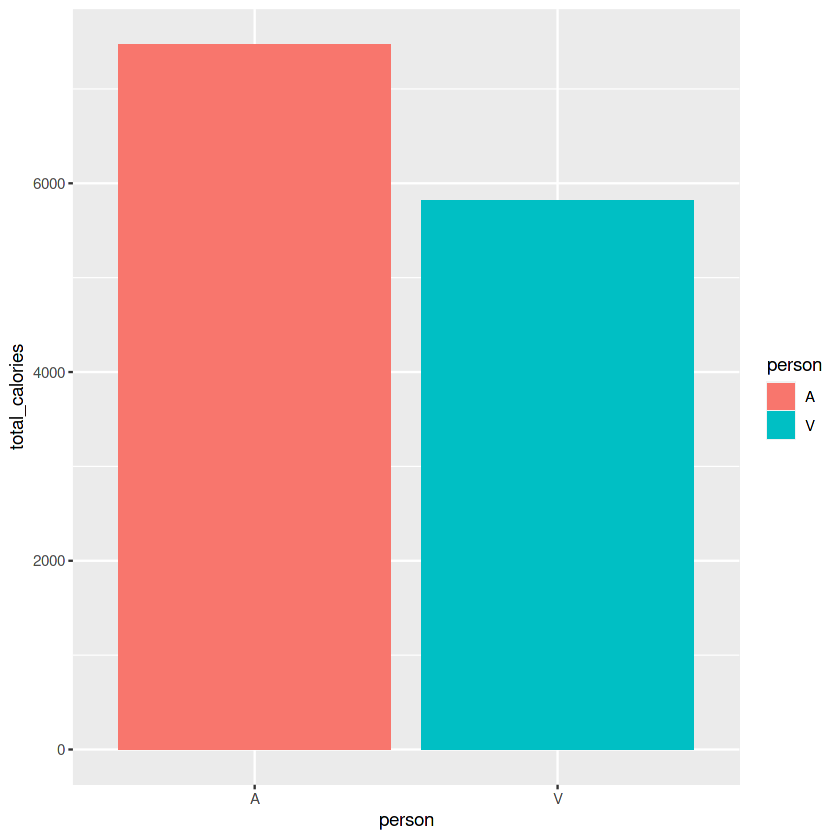

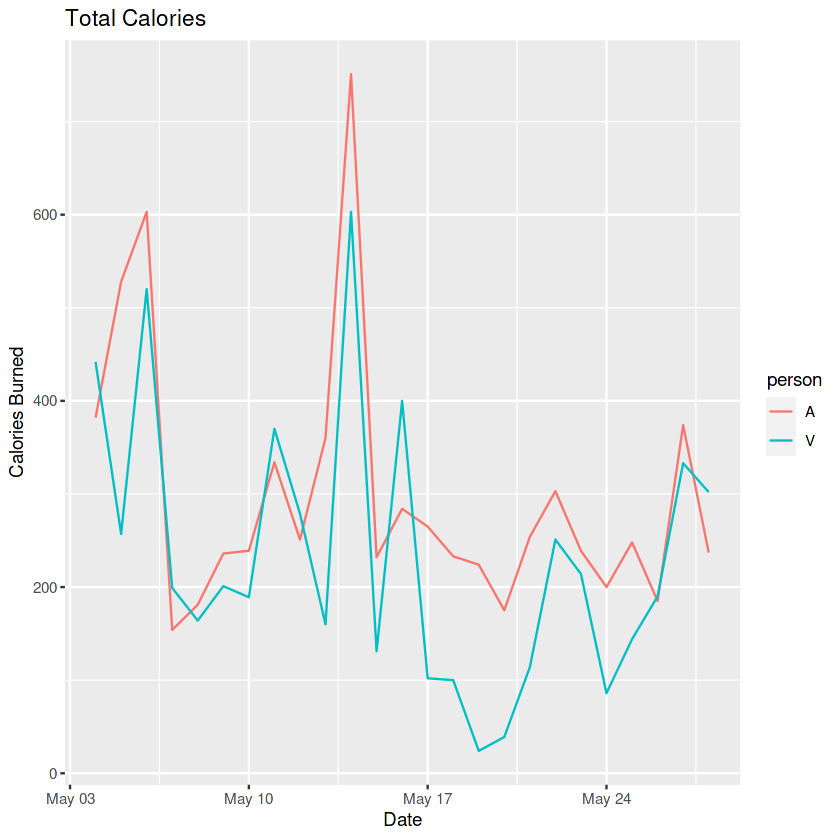

In [15]:
aggregate(x = fitness$total_calories,     
         by = list(fitness$person),      
         FUN = mean)

ggplot(data=fitness, aes(person,total_calories, fill = person)) +
    geom_bar(stat = "identity")

ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=total_calories,group=person, color = person), stat = "identity")+
       labs(title = "Total Calories", x = "Date", y="Calories Burned")

A comparison between the two participants shows that, on average, A is more active than V in terms of total calories burned in activities per day. Also, worth nothing, A is more consistent in keeping up a more stable level of active lifestyle. Both are subject to huge spikes of increased phisical activity. Spikes are corelated with non-working days.

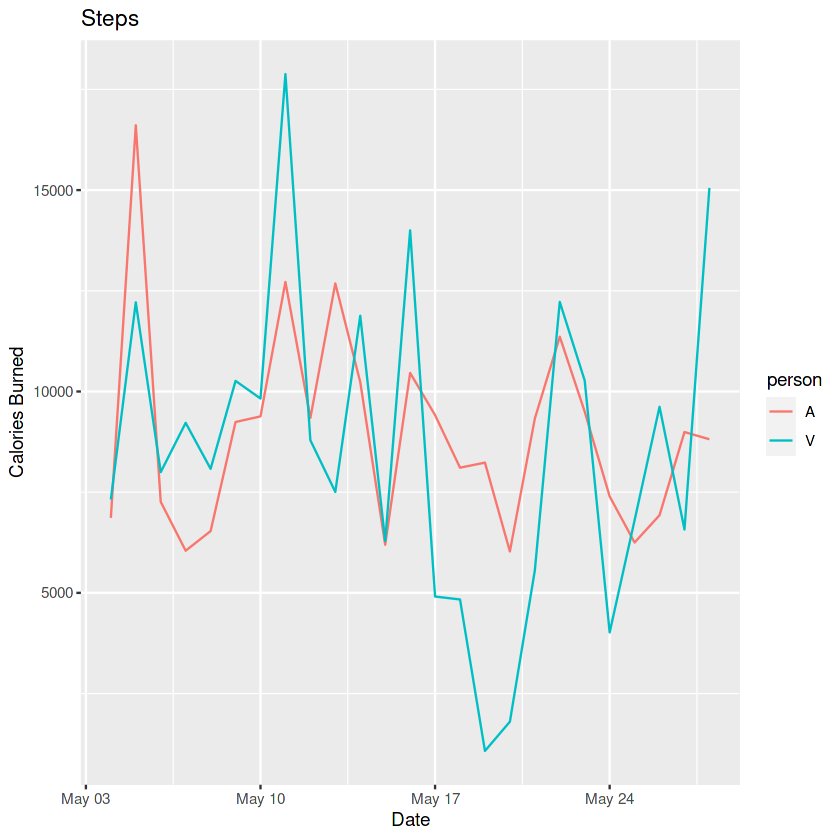

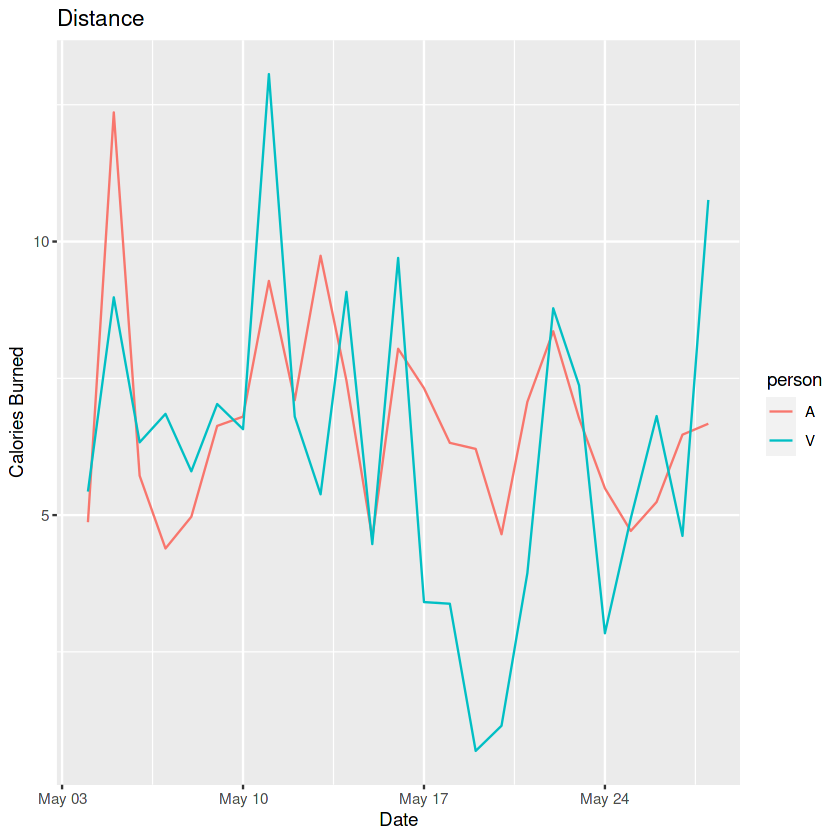

In [16]:
ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=steps,group=person, color = person), stat = "identity")+
       labs(title = "Steps", x = "Date", y="Calories Burned")

ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=distance,group=person, color = person), stat = "identity")+
       labs(title = "Distance", x = "Date", y="Calories Burned")


A has a more stable and consistent rate of steps/distance, with V having huge spikes or dips in both.

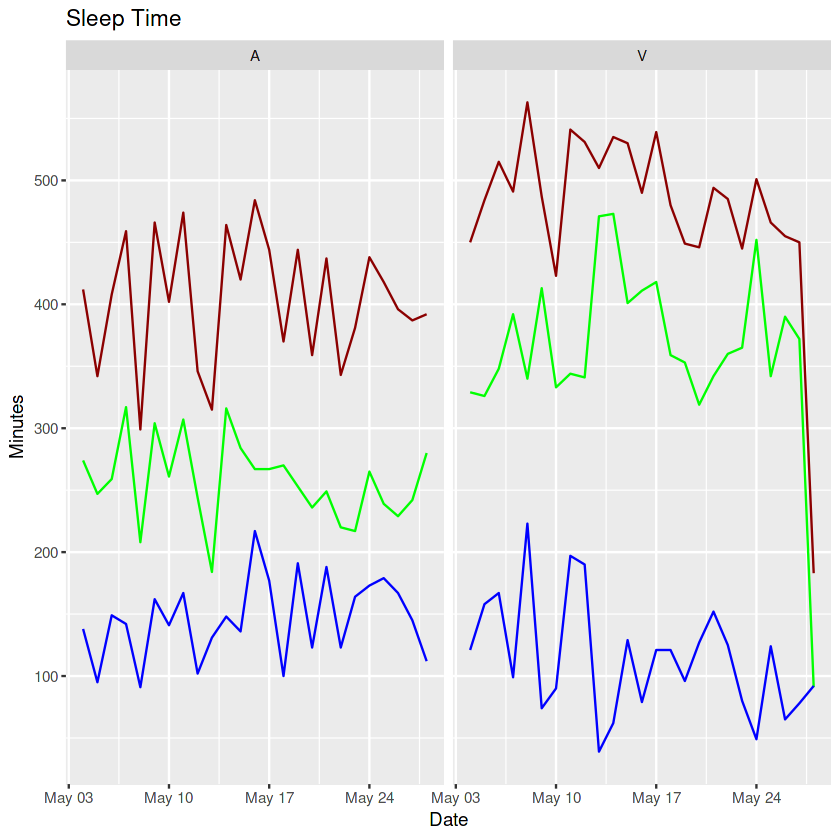

In [17]:
ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=light_sleep), color = "green", stat = "identity")+
       geom_line(mapping = aes(x=date,y=deep_sleep), color = "blue", stat = "identity")+
       geom_line(mapping = aes(x=date,y=total_sleep), color = "darkred", stat = "identity")+
       facet_wrap(~person)+
       labs(title = "Sleep Time", x = "Date", y="Minutes")

V has a total sleeping time which is higher than A's, but A's deep sleep time is higher.
There's also a night with very few sleep time for V.

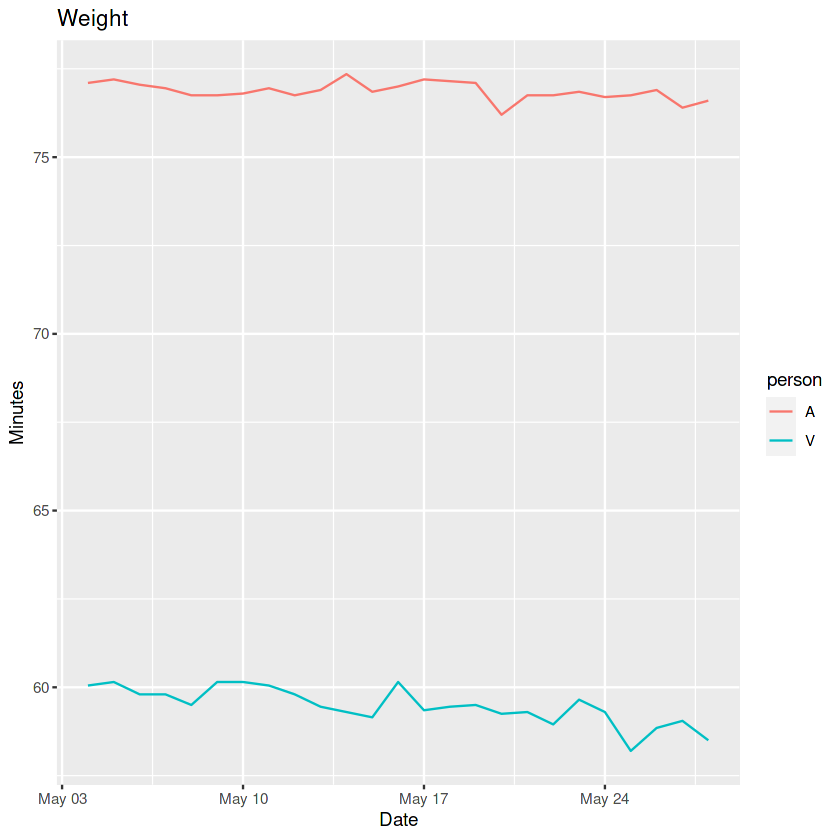

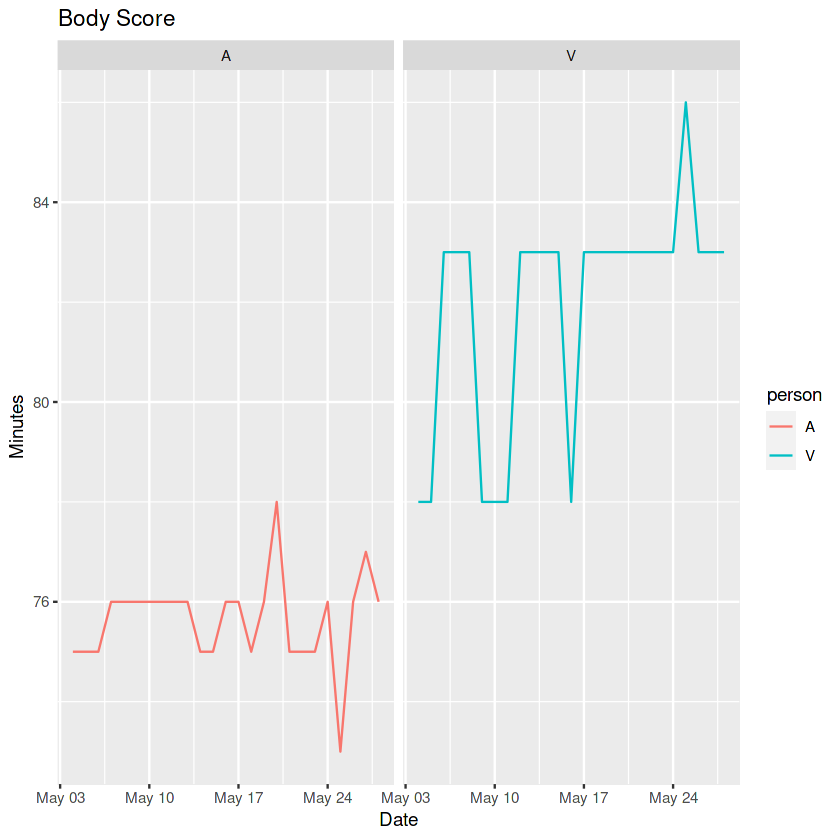

In [18]:
ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=weight, color=person), stat = "identity")+
       labs(title = "Weight", x = "Date", y="Minutes")

ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=body_score, color=person), stat = "identity")+
       facet_wrap(~person)+
       labs(title = "Body Score", x = "Date", y="Minutes")

Both participants report a slight decrease in weight at the end of the month, and stable body score. V has a much higher body score and a lower weight.

Overall, A has a higher and more consistently active lifestyle, a higher deep sleep minute count, but V has a higher body score. This would suggest that even if not as active as A, V has had a more consistently healthy diet in the long run. While A is more active, it would suggest current level of activity needs to be increased and a change in diet is needed in order to lower weight and gain body score. 

It could also be noted that a significant change in health indicators, appart from effort, need time to materialize. One month is not enough to measure and determine this.

## Lifestlye investigation
I know it sounds fancy, and of course we would need to incorporate calories or even a nutritional intake for a full analysis, but the next thing I want to see if that we are able to spot if sleeping more, or if exercising more leads to a better sleep, or exercising more has an effect on weight.

The first thing I wanted to do is investigate if being active in a day leads to a better sleep time.

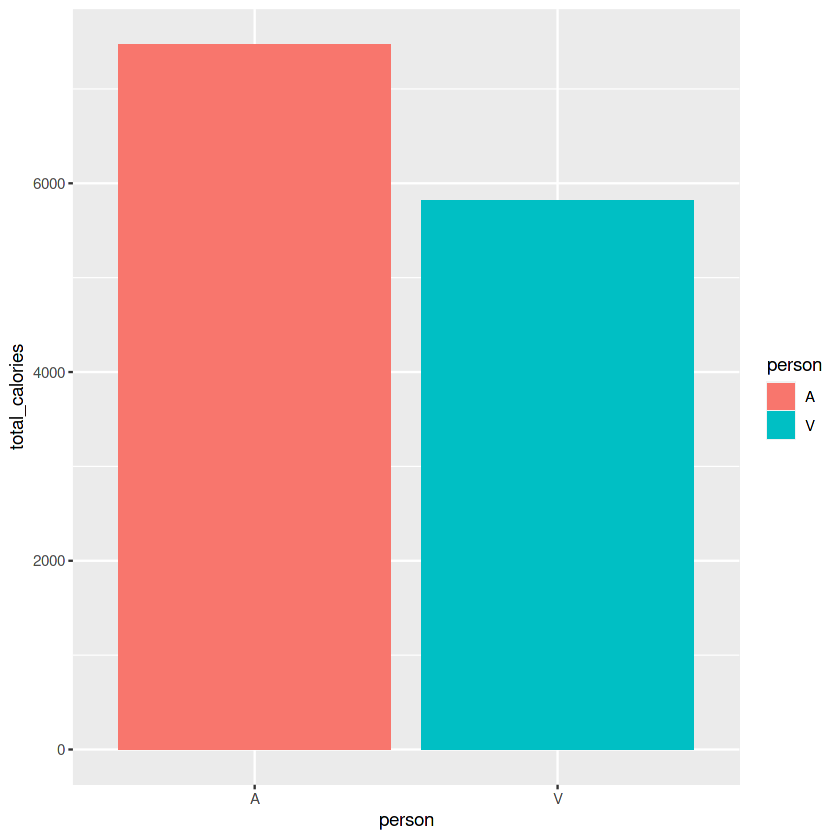

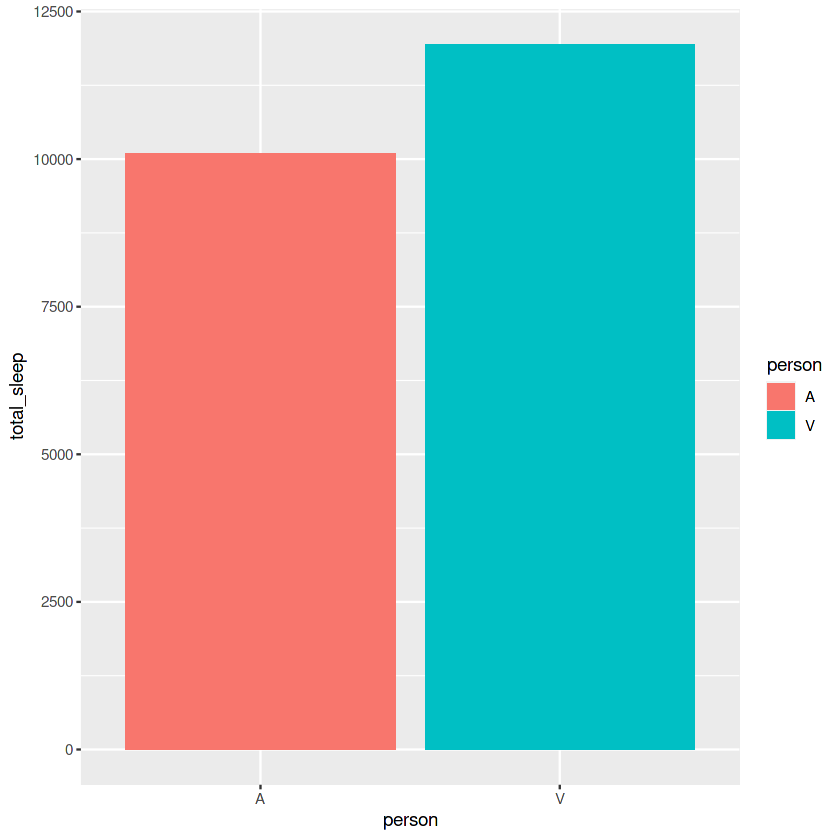

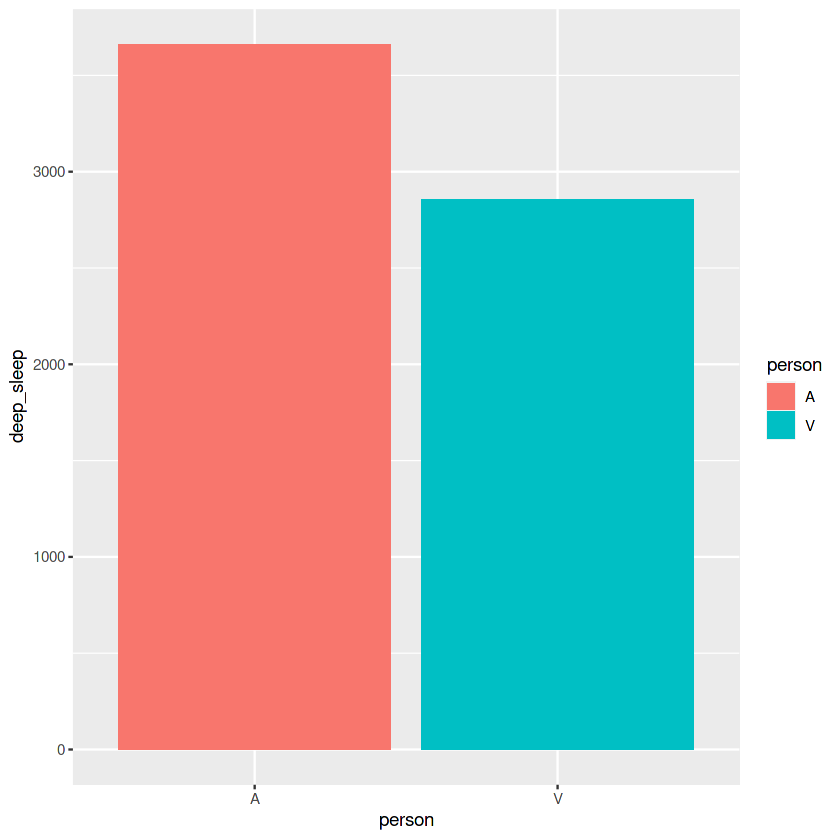

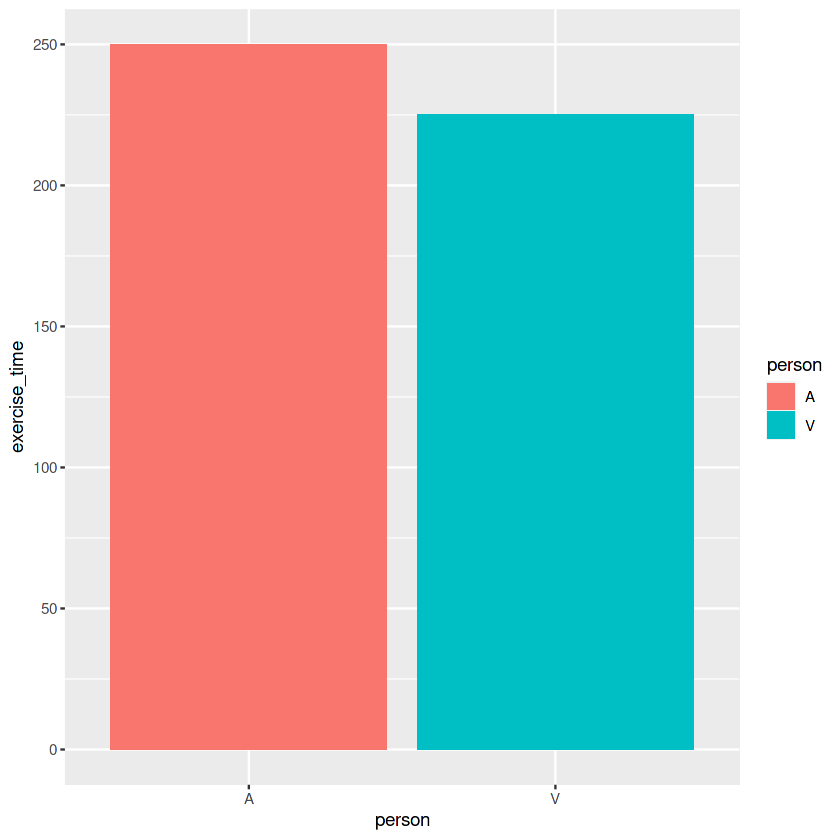

In [19]:
ggplot(data=fitness, aes(person,total_calories, fill = person)) +
    geom_bar(stat = "identity")

ggplot(data=fitness, aes(person, total_sleep, fill = person)) +
    geom_bar(stat = "identity")

ggplot(data=fitness, aes(person, deep_sleep, fill = person)) +
    geom_bar(stat = "identity")

ggplot(data=fitness, aes(person, exercise_time, fill = person)) +
    geom_bar(stat = "identity")

At first glance, even if A has been burning more calories, V is still having a better sleep. But, as it seems, the quality of the sleep is determined by the amount of deep sleep, which is higer for A, fact which is also consistent with A having more time spent exercising than V.

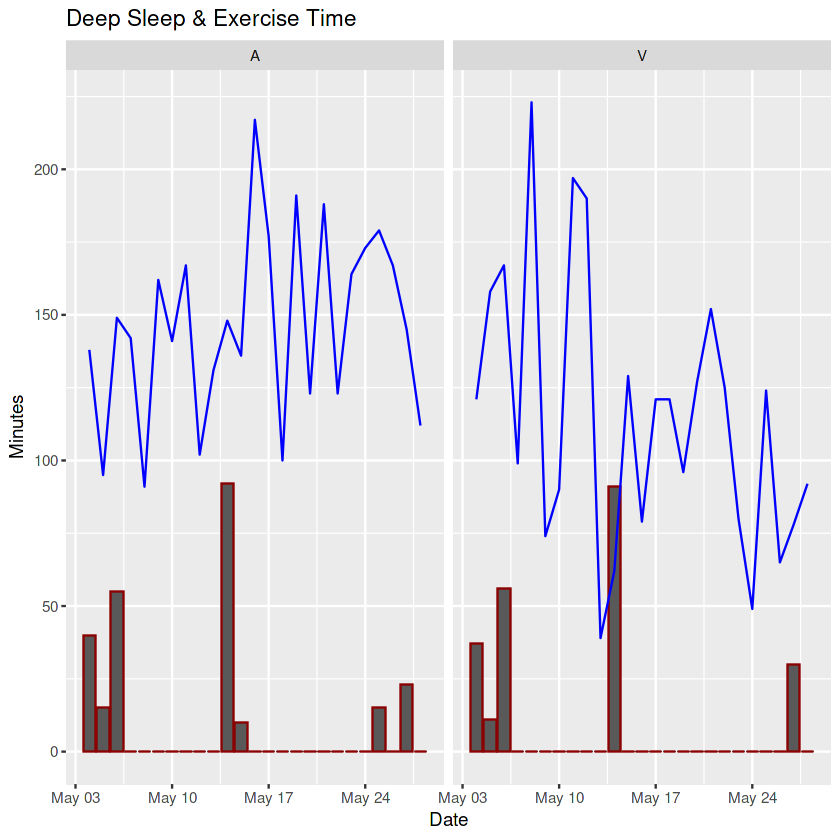

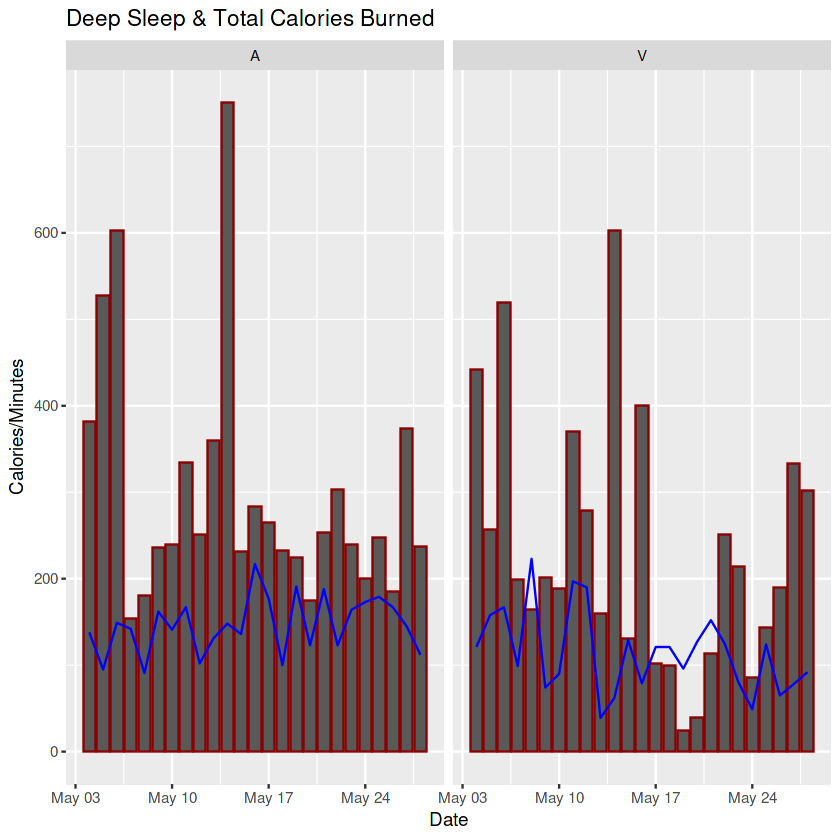

In [20]:
ggplot(data=fitness)+
       geom_bar(mapping = aes(x=date,y=exercise_time), color = "darkred", stat = "identity")+
       geom_line(mapping = aes(x=date,y=deep_sleep), color = "blue", stat = "identity")+
       facet_wrap(~person)+
       labs(title = "Deep Sleep & Exercise Time", x = "Date", y="Minutes")


ggplot(data=fitness)+
       geom_bar(mapping = aes(x=date,y=total_calories), color = "darkred", stat = "identity")+
       geom_line(mapping = aes(x=date,y=deep_sleep), color = "blue", stat = "identity")+
       facet_wrap(~person)+
       labs(title = "Deep Sleep & Total Calories Burned", x = "Date", y="Calories/Minutes")

While not imediate and due to a lack of observations, we can see that increase in activity does lead to a better deep sleep overall in the following couple of days. In order to make a better assement, more observations are needed.
The same can be said after a more active day (which includes more walking).

Next, lets see if all this activity is translated into a better weight loss. I would want to do the same with body score, but since there is no change on it, we can note that it takes more time until an effect in body score is visible.

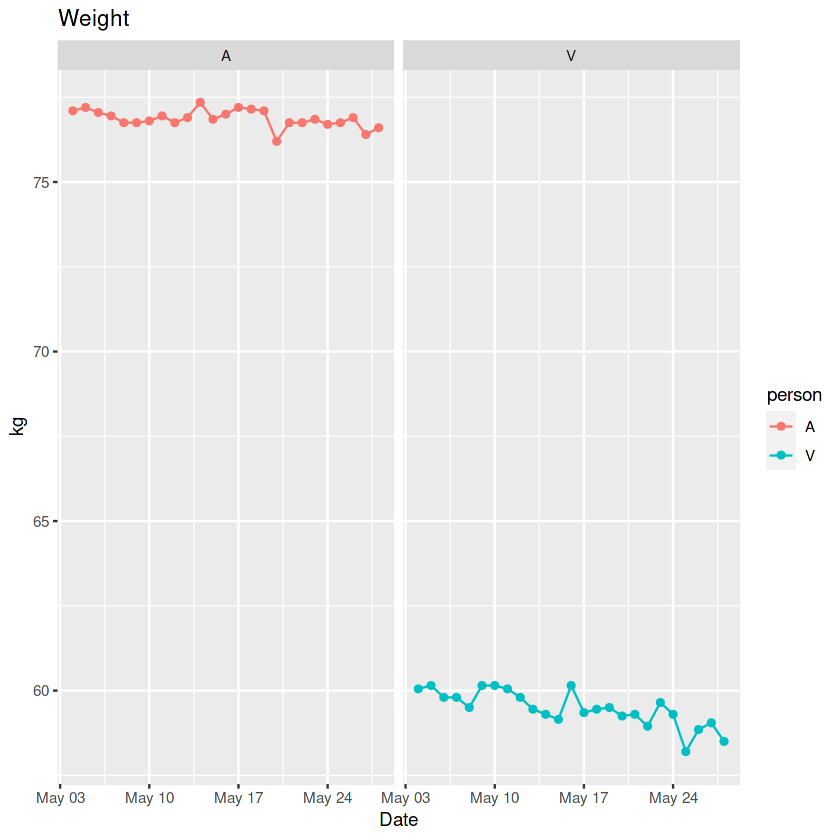

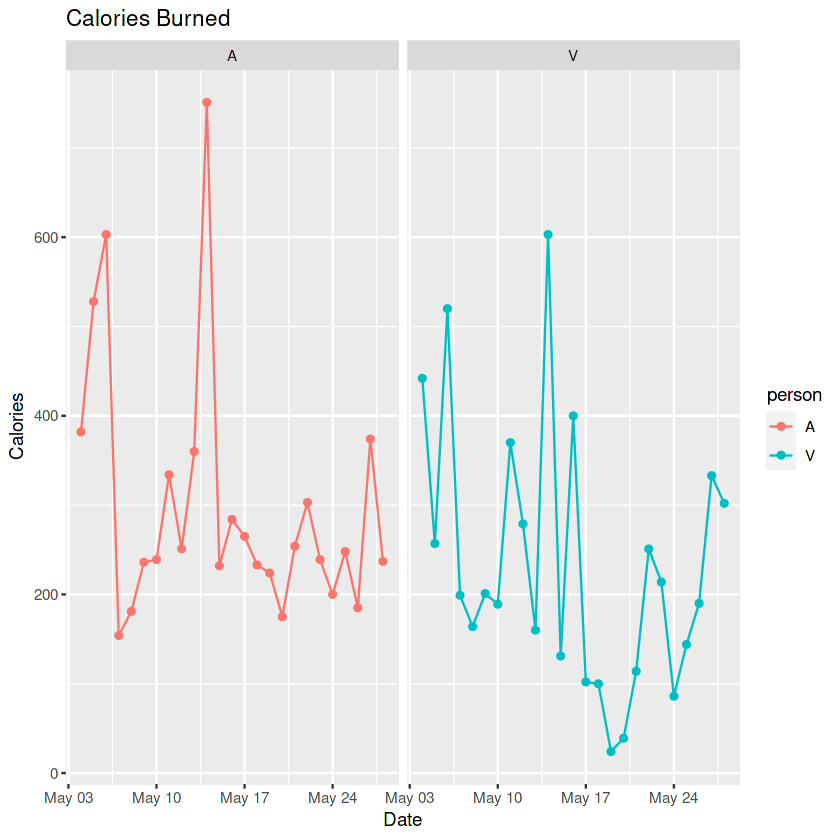

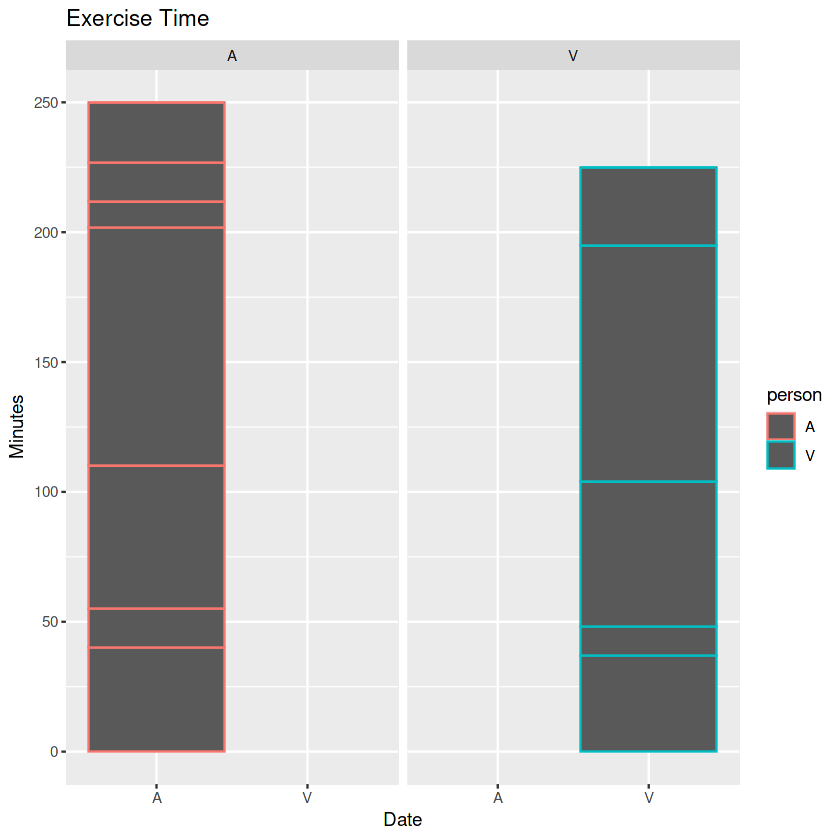

In [21]:
ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=weight, color=person), stat = "identity")+
       labs(title = "Weight", x = "Date", y="kg")+
       geom_point(mapping = aes(x=date,y=weight, color=person), stat = "identity") +
       facet_wrap(~person)

ggplot(data=fitness)+
       geom_line(mapping = aes(x=date,y=total_calories, color=person), stat = "identity")+
       facet_wrap(~person)+
       geom_point(mapping = aes(x=date,y=total_calories, color=person), stat = "identity") +
       labs(title = "Calories Burned", x = "Date", y="Calories")

ggplot(data=fitness)+
       geom_bar(mapping = aes(x=person, y=exercise_time, color=person), stat = "identity")+
       facet_wrap(~person)+
       labs(title = "Exercise Time", x = "Date", y="Minutes")

Calories burned are either too few or do not have a major impact on weight as a whole. Same goes with exercise time. Overall, V looks to have lost more weight than A.

This suggests that either there were not enough calories burned through exercises in order to have a significant impact, or that dieting is more important than exercising in terms of weight loss. This is also in line with recent finds which puts more stress on reducing calories intake than exercises when trying to lose weight.

## Calories by phisical activity

Even if we have just a small amounts of data, we can try and get a sense of which phisical activity involves more calories burning with less effort.

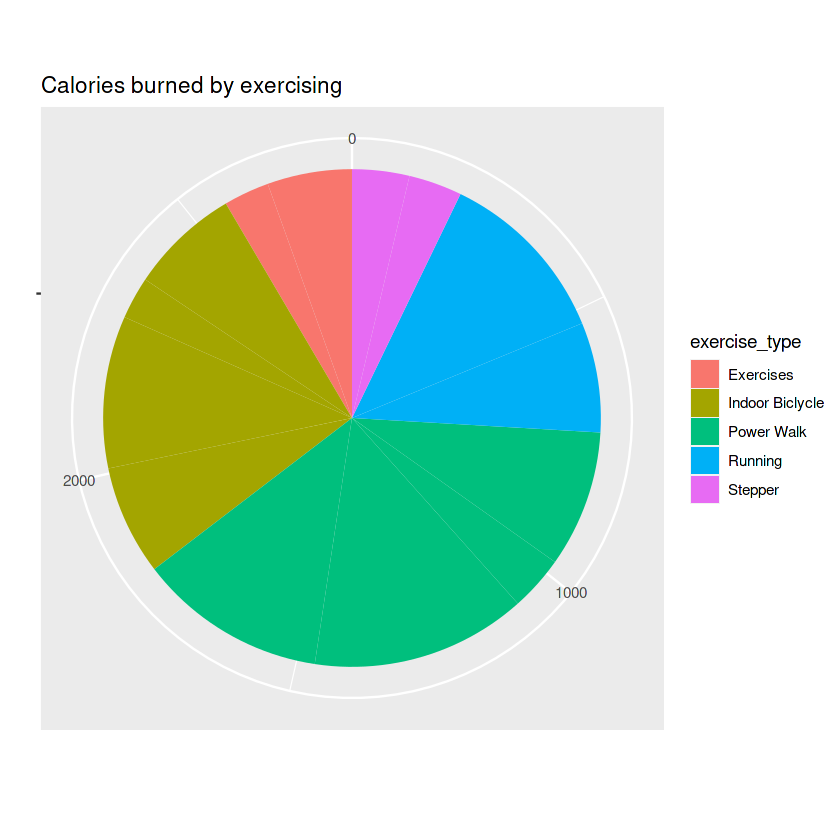

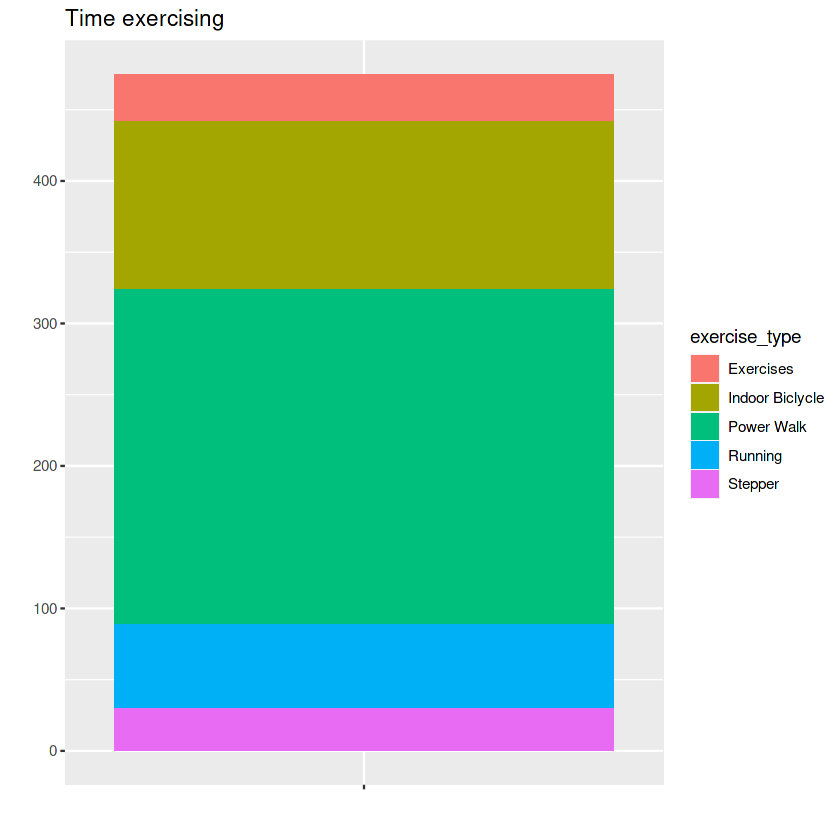

In [22]:
ggplot(data=new.exercises_v3)+
    geom_bar(aes("",exercise_calories, fill= exercise_type), stat = "identity")+
    coord_polar("y", start=0)+
    labs(title = "Calories burned by exercising",x="",y="")

ggplot(data=new.exercises_v3, aes("",exercise_time, fill= exercise_type))+
    geom_bar(stat = "identity", width=1)+
    labs(title = "Time exercising",x="",y="")

At first glance, we can see that power walks have occupied most minutes in terms of exercising, close to 50%, but do not yield good results in terms of calories/minute burned. Running seems to be most potent when it comes to losing weight. Indoor cycling also seems to yield better results.

This would recommend not employing power walks when trying to exercise and lose weight.

# Conclusions

Main takeaway from this analysis, which is an eye-opener for me, is that there needs to be more physical activity involved. While it does not help in losing weight, it does help in having a better sleep. Running seems to be the most intensive exercise and there needs to be more of it.

The personal project, which we call “Yarny” after the characters from Unravel (a PS4 co-op game which we enjoyed during this stay at home period), will continue and should include calories intake, nutritional composition and a longer period of time. Also, we need to have a better look at the data we are logging in because some of it was not correct and this could impact our research when we decide that we have enough data.


# Acknowledgements 
I would like to thank Google for this huge opportunity for me to learn what it takes to be a data analyst. I have learned a lot, I didn’t even know 10% before starting this course. It was a huge lean in knowledge and, while at times hard and exhausting, I can say that the efforts in these past 3 months were worth it. 
Maybe I’m not going to start working as a data analyst in the near future, but the skills here have already had a big impact on the way I approach my job tasks and the way I think and act in terms of managing personal data.

CHEERS! 